# Performance Comparison

Performance with basic LSTM Model


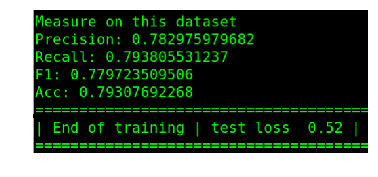

Performance with Self-Attentive Model


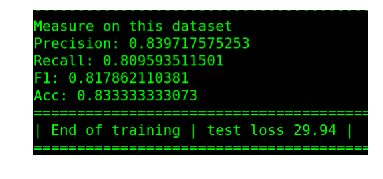

Performance with Self-Attentive Model - Noise Removed & Stemmed


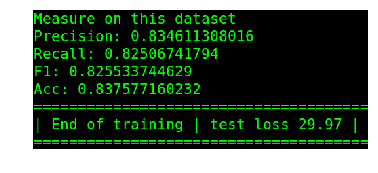

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


print 'Performance with basic LSTM Model'
image = mpimg.imread( 'Results/noise & no stem/BasicLSTM.png' )

plt.axis('off')
plt.imshow( image )
plt.show()

print 'Performance with Self-Attentive Model'
image = mpimg.imread( 'Results/noise & no stem/AttentionResults.png' )
plt.axis('off')
plt.imshow( image )
plt.show()

print 'Performance with Self-Attentive Model - Noise Removed & Stemmed'
image = mpimg.imread( 'Results/no noise & stem 500/AttentionResults-500.png' )
plt.axis('off')
plt.imshow( image )
plt.show()

# Loading Attention Weights

In [2]:
import torch

cuda = True
path = 'data/'
test_batch_size = 32

# Load Attention weights
Weights = torch.load( 'Results/no noise & stem 500/attention_weights.pt' )

# Review Loading and Tokenization

In [3]:
import csv
from nltk.tokenize import word_tokenize

ReviewsAndTokens = []
count = 0
# Test dataset
with open( path + 'test.csv', 'r' ) as f:
    Reader = csv.reader( f, delimiter=',', quoting=csv.QUOTE_MINIMAL )
    for i, record in enumerate( Reader ):
        content = record[ 0 ]
        tokens = content.decode('utf-8').split()
        
        temp = [ content, tokens, record[1] ]
        ReviewsAndTokens.append( temp )
        count += 1
    
nbatch = count // test_batch_size
batchifiable = nbatch * test_batch_size

batchedReviewsAndTokens = ReviewsAndTokens[ :batchifiable ]

In [4]:
reviewAndweights = []
for i in range( 0, batchifiable - 1, test_batch_size ):

    for j in range( test_batch_size ):
        record = batchedReviewsAndTokens[ i+j ]
        record.extend( [ i, j ] )
        reviewAndweights.append( record )

# Attention Visualization on Reviews

In [5]:
def Highlight( string ):
    return "\x1b[31m" + string + "\x1b[0m"

reviewNum = 20
start = 0
end = start + reviewNum
words2show = 10

for reviewID in range( start , end ):
    sample_review = batchedReviewsAndTokens[ reviewID ][ 0 ]
    sample_tokens = batchedReviewsAndTokens[ reviewID ][ 1 ]
    helpful = batchedReviewsAndTokens[ reviewID ][ 2 ]
    weights = Weights[ batchedReviewsAndTokens[ reviewID ][3] ][ 0 ][ batchedReviewsAndTokens[ reviewID ][ 4 ] ].data
    
    # print weights

    vector = weights.sum( 0 )
    vector = vector / vector.sum()
    att, ids_to_show =  vector.sort( 0, descending=True )

    ids_to_show = ids_to_show.squeeze( 0 ).tolist()[:words2show]

    print 'Sample Review:'

    sent = ''
    for idx in range( len( sample_tokens ) ):
        if idx in ids_to_show:
            sent += ' ' + Highlight( sample_tokens[ idx ] )
        else:
            sent += ' ' + sample_tokens[ idx ]
    print sent
    
    print ''
    print 'Helpful?'
    print helpful
    print ''
        
    print '--' * 59

Sample Review:
 oh , how i want to love this hotel . ( it ' s really 1 1/ 2 star ) i be in town for a conference and want to make sure that i have time to wind down . the review have largely be favorable so i be definitely look forward to my stay . however , it all begin at 3 : 30pm on monday , 4/ 25. monday , 4/ 25arrived at 3 : 30pm and be tell that there be no room ready . check in time be at 4pm i ' m tell . ok. while i check into hotel all the time well before the posted check in time , it be a fact , that i appear at the desk before the 4pm state check in time . kenya , one of the lady at the front desk , instruct me that my room would be ready in 1/ 2 hour ( 4pm ) and that she would call me . i really don ' t like disappear in these situation . i believe most organization have a philosophy of `` out of sight , out of mind '' so i like to hang around . however , seat option be few - - with a couple of family already take up the small seating area - - so i trudge back to my rent k

# Sentence Highlight based on Average Attention Weights

In [34]:
from nltk.tokenize import sent_tokenize
import numpy as np

def Highlight( string ):
    return "\x1b[31m" + string + "\x1b[0m"

reviewNum = 20
start = 100
end = start + reviewNum
sent2show = 5

for reviewID in range( start , end ):
    sample_review = batchedReviewsAndTokens[ reviewID ][ 0 ]
    sentences = sent_tokenize( sample_review )
    lens = [ len( sent.split() ) for sent in sentences ]
    
    sample_tokens = batchedReviewsAndTokens[ reviewID ][ 1 ]
    helpful = batchedReviewsAndTokens[ reviewID ][ 2 ]

    weights = Weights[ batchedReviewsAndTokens[ reviewID ][3] ][ 0 ][ batchedReviewsAndTokens[ reviewID ][ 4 ] ].data
    vector = weights.sum( 0 )
    
    # Calculate average weight for each sentence
    sent_avg_weight = []
    for idx, sent_len in enumerate( lens ):
        if idx > 0:
            pre_token_num = sum( lens[:idx-1] )
        else:
            pre_token_num = 0
            
        sent_weights = vector[ 0, pre_token_num:pre_token_num + sent_len ]
        sent_avg_weight.append( sent_weights.mean() )
    
    # Get TopK sentence based on average weights
    ids2show = np.flip( np.argsort( np.array( sent_avg_weight ) ), 0 )
    count = 0
    sents2show = []
    for idx in ids2show:
        if lens[ idx ] > 10:
            sents2show.append( idx )
            count += 1
            if count == sent2show:
                break
        else:
            continue

    print 'Sample Review:'
    
    Review = ''
    for idx, sent in enumerate( sentences ):
        if idx in sents2show:
            Review += ' ' + Highlight( sent )
        else:
            Review += ' ' + sent
            
    print Review
    
    print ''
    print 'Helpful?'
    print helpful
    print ''
        
    print '--' * 59

Sample Review:
 my family and i stay here for 5 day . we arrive in orlando earlier then we have plan ( around 10 : 30am ) . we decide to check in to the cabana bay early knowing that they would text when our room be ready . i be glad we decide to do that because we be check in and give a room right away . 2nd floor and pool side , this be awesome ! so we have just make our way from michigan which take night of sleep in other hotel to get here . when we finally get to our room we be very pleased ! kitchen with fridge and microwave , live room with a pull out couch and television , bedroom with two queen size bed and 3d television , toilet in it own room and two sink and shower in it own room . the pool be amazing ( there be two ) but the best one be just behind the lobby . it be only 4 ' deep but there be a water slide and plenty of room to swim . at the other pool there be a lazy river . i can not tell you much about this because you either have to have your own tube or buy tube from t

# Embedding Visualization via t-SNE

In [20]:
# t-SNE
import torch
import numpy as np
import csv

# Load Features, Labels
Features = torch.load( 'fc_features.pt' )

Embeddings = np.empty( [ 0, 3000 ] )
for i in range( 0, 2591, 32 ):
    Embeddings = np.concatenate( ( Embeddings, Features[ i ].data.cpu().numpy() ), axis=0 ) 

GT = []
with open( 'data/test.csv', 'r' ) as f:
    Reader = csv.reader( f, delimiter=',', quoting=csv.QUOTE_MINIMAL )
    for record in Reader:
        GT.append( int( record[ 1 ] ) )
        
GT = GT[:2592]

In [31]:
# Map 3000-d feature into 2-d via t-SNE
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

model = TSNE( n_components=2, random_state=0 )
np.set_printoptions( suppress=True )
pca = PCA(n_components=2)

Points = model.fit_transform( Embeddings ) 
Points_pca = pca.fit_transform( Embeddings )

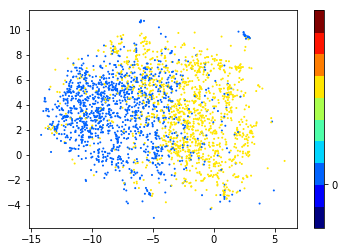

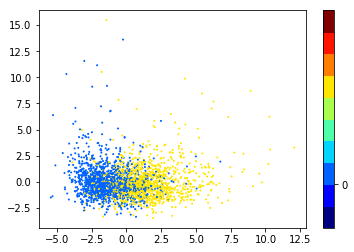

In [38]:
# Scatter Plot
from matplotlib import pyplot as plt

# plot the result
vis_x = Points[:, 0]
vis_y = Points[:, 1]

pca_x = Points_pca[ :, 0 ]
pca_y = Points_pca[ :, 1 ]

plt.scatter( vis_x, vis_y, s=1, c=GT, cmap=plt.cm.get_cmap( "jet", 10 ) )
plt.colorbar( ticks=range(1) )
plt.clim( -0.5, 2 )
plt.show()

plt.scatter( pca_x, pca_y, s=1, c=GT, cmap=plt.cm.get_cmap( "jet", 10 ) )
plt.colorbar( ticks=range(1) )
plt.clim( -0.5, 2 )
plt.show()